In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Importing the dataset
file_name = "frequency_data"
data = pd.read_csv(f"data/cleaned_data/{file_name}.csv")

dtypes = pd.read_csv(f"data/cleaned_data/{file_name}_dtypes.csv", index_col=0)
data = data.astype(dtypes.to_dict()["0"])

data["datetime"] = data["time"]
data.drop("time", axis=1, inplace=True)


In [3]:
def filter_room_id(data, room_id):
    return data[data["room_id"] == room_id].reset_index(drop=True)

def filter_event_type(data, event_type):
    return data[data["event_type"] == event_type].reset_index(drop=True)

In [4]:
## only one lecture hall
#data = filter_room_id(data, 0)
## only entering events
#data = filter_event_type(data, 1)

# 1. Basic Visualizations

## 1.0 Prepare Data

In [5]:
data_filterd = filter_room_id(data, 0)
data_filterd = filter_event_type(data_filterd, 1)

def resample(data, time_column, frequency, agg_func):
    
    # get min day
    if frequency == "MS":
        min_time = min(data[time_column]).replace(day=1, hour=0, minute=0, second=0)
    else:
        min_time = min(data[time_column]).replace(hour=0, minute=0, second=0)

    # get max day
    max_time = max(data[time_column])
    max_time = max_time.replace(day=max_time.day+1, hour=0, minute=0, second=0)
    
    
    idx = pd.date_range(start=min_time, end=max_time, freq=frequency, inclusive="both") 

    df_resampled = data.set_index(time_column)\
                   .resample(frequency, label="left", closed="left")

    if agg_func == "sum":
        df_resampled = df_resampled.sum()
    elif agg_func == "count":
        df_resampled = df_resampled.count()
    elif agg_func == "value_counts":
        df_resampled = df_resampled.value_counts()
    else:
        raise ValueError("agg_func must be 'sum', 'count' or 'value_counts'")
    return df_resampled.reindex(idx, fill_value=0).reset_index().rename(columns={"index": time_column})[[time_column, "event_type"]]


In [6]:
offset_week = pd.tseries.offsets.Week(weekday=0)
offset_month = "MS"
data_resampled = resample(data_filterd, "datetime", offset_week, "count")

## 1.1 Basic Time Plot

In [7]:
# Plotting the data
data_resampled = resample(data_filterd, "datetime", "15min", "count")
fig = go.Figure()
# line plot
fig.add_trace(go.Scatter(x=data_resampled["datetime"], y=data_resampled["event_type"], mode='lines', name='lines'))


## 1.2 Time Series Patterns

### Also plot the respective ACF plots

In [8]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("per Hour", "Per Day", "Per Week", "Per Month"))


freq = "1h"
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="hour"
    ),
    row=1, col=1
)

freq = "1d"
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="day"
    ),
    row=1, col=2
)

freq = pd.tseries.offsets.Week(weekday=0)
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="week"
    ),
    row=2, col=1
)

freq = "MS"
data_resampled = resample(data_filterd, "datetime", freq, "count")
fig.add_trace(
    go.Scatter(
        x=data_resampled["datetime"],
        y=data_resampled["event_type"],
        mode='lines',
        name="month"
    ),
    row=2, col=2
)

fig.show()

## 1.3 Seasonal Plots

Could be averaged or aggregated over weeks

In [9]:
def derive_day(data):
    data["day"] = data["datetime"].dt.date
    return data

def derive_week(data):
    data["week"] = data["datetime"].dt.isocalendar().week
    return data

def derive_time(data):
    data["time"] = data["datetime"].dt.time
    return data

### 1.3.1 Compare Days

In [10]:
# Plot daily patterns

data_resampled = resample(data_filterd, "datetime", "15min", "count")
data_resampled = derive_day(data_resampled)
data_resampled = derive_time(data_resampled)

fig = px.line(data_resampled, x="time", y="event_type", color="day")
fig.show()

In [11]:
data_resampled

,datetime,event_type,day,time
0,2024-04-08 00:00:00,0,2024-04-08,00:00:00
1,2024-04-08 00:15:00,0,2024-04-08,00:15:00
2,2024-04-08 00:30:00,0,2024-04-08,00:30:00
3,2024-04-08 00:45:00,0,2024-04-08,00:45:00
4,2024-04-08 01:00:00,0,2024-04-08,01:00:00
...,...,...,...,...
7868,2024-06-28 23:00:00,0,2024-06-28,23:00:00
7869,2024-06-28 23:15:00,0,2024-06-28,23:15:00
7870,2024-06-28 23:30:00,0,2024-06-28,23:30:00
7871,2024-06-28 23:45:00,0,2024-06-28,23:45:00


In [12]:
#fig = go.Figure()

#for day in data_resampled["day"].unique():
#    fig.add_trace(go.Scatterpolar(
#        r=data_resampled[data_resampled["day"]==day]["event_type"],
#        theta=data_resampled[data_resampled["day"]==day]["time"], 
#        mode='lines',
#        name=str(day),
#    ))

#fig.update_layout(
#    polar=dict(
#        angularaxis=dict(
#            direction="clockwise",
#            dtick=2,
#        )
#    ),
#    height=750,
#    width=1000,
#    showlegend=True,
#    margin=dict(l=0, r=0, t=35, b=35)
#)

### 1.3.2 Compare Weeks


In [13]:
def exclude_weekdays(data, weekdays):
    data["dayofweek"] = data["datetime"].dt.dayofweek
    return data[~data["dayofweek"].isin(weekdays)]

In [14]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")
#data_resampled = derive_day(data_resampled)
data_resampled = derive_time(data_resampled)
data_resampled = derive_week(data_resampled)
#data_resampled = exclude_weekdays(data_resampled, [6,7])

data_resampled = data_resampled.drop("datetime", axis=1)

#sum
data_resampled = data_resampled.groupby(["week", "time"]).sum().reset_index()
#mean
#data_resampled = data_resampled.groupby(["week", "time"]).median().reset_index()

fig = px.line(data_resampled, x="time", y="event_type", color="week")
fig.show()

## 1.4 Autocorrelation Plot

In [15]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")

data_resampled.head()

,datetime,event_type
0,2024-04-08 00:00:00,0
1,2024-04-08 00:15:00,0
2,2024-04-08 00:30:00,0
3,2024-04-08 00:45:00,0
4,2024-04-08 01:00:00,0


In [16]:
data_resampled.loc[96]

datetime      2024-04-09 00:00:00
event_type                      0
Name: 96, dtype: object

In [17]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")

lag_list = list(range(0, 1000))
auto_corr = [data_resampled["event_type"].autocorr(lag=i) for i in lag_list]

#fig.add_trace(go.bar(x=data_resampled["datetime"], y=data_resampled["event_type"], mode='lines', name='lines'))

fig = go.Figure()
# line plot
fig.add_trace(
    go.Bar(
        x=lag_list,
        y=auto_corr,
        name='Auto Correlation'
    )
)

# 2. Simple Forcasting methods

In [18]:
data_resampled = resample(data_filterd, "datetime", "15min", "count")
dataset = data_resampled[data_resampled["datetime"] < datetime(2024, 6, 24)]

trainset = dataset[dataset["datetime"] < datetime(2024, 6, 10)].set_index("datetime").copy()
testset = dataset[dataset["datetime"] >= datetime(2024, 6, 10)].set_index("datetime").copy()

In [19]:
def plot_results(train, test, column_name, predictions, method_name):
    plt.figure(figsize=(12,8))
    
    plt.plot(train.index, train[column_name], label='Train')
    plt.plot(test.index, test[column_name], label='Test')    
    plt.plot(predictions.index, predictions, label=method_name)
    
    plt.legend(loc='best')
    plt.show()

## 2.1 Naive methods

In [20]:
y_hat = testset.copy()
y_hat["naive"] = trainset["event_type"][len(trainset)-1]

/tmp/ipykernel_486565/2386040615.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



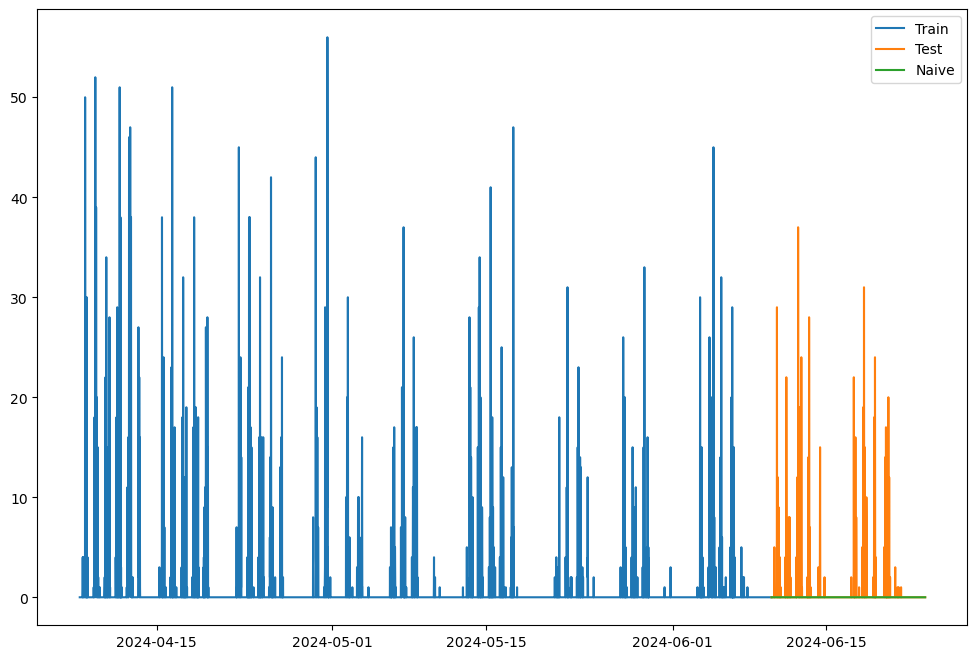

In [21]:
plot_results(trainset, testset, "event_type", y_hat["naive"], "Naive")

## 2.2 Seasonal naive method

In [22]:
season_offset = 4*24*7

In [23]:
y_hat = testset.copy()

preds =  trainset["event_type"][-season_offset:]
preds.index = testset.index[:season_offset]

preds

datetime
2024-06-10 00:00:00    0
2024-06-10 00:15:00    0
2024-06-10 00:30:00    0
2024-06-10 00:45:00    0
2024-06-10 01:00:00    0
                      ..
2024-06-16 22:45:00    0
2024-06-16 23:00:00    0
2024-06-16 23:15:00    0
2024-06-16 23:30:00    0
2024-06-16 23:45:00    0
Name: event_type, Length: 672, dtype: int64

In [24]:

# import mean absolute error and root mean squared error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_results(target_values, predictions):
    # mae
    mae = mean_absolute_error(target_values, predictions)
    # mse
    mse = mean_squared_error(target_values, predictions)
    # mase
    numerator = np.mean(np.abs(target_values - predictions))
    denominator = np.mean(np.abs(target_values[1:] - target_values[:-1]))
    mase = numerator / denominator
    #r2
    r2 = r2_score(target_values, predictions)
    
    # print results
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"Mean Absolute Percentage Error: {mase}")
    print(f"R2 Score: {r2}")
    

evaluate_results(testset["event_type"].values[:season_offset], preds.values)


Mean Absolute Error: 0.6532738095238095
Root Mean Squared Error: 2.8475657942145873
Mean Absolute Percentage Error: 0.7233444326575516
R2 Score: 0.11277466776249478


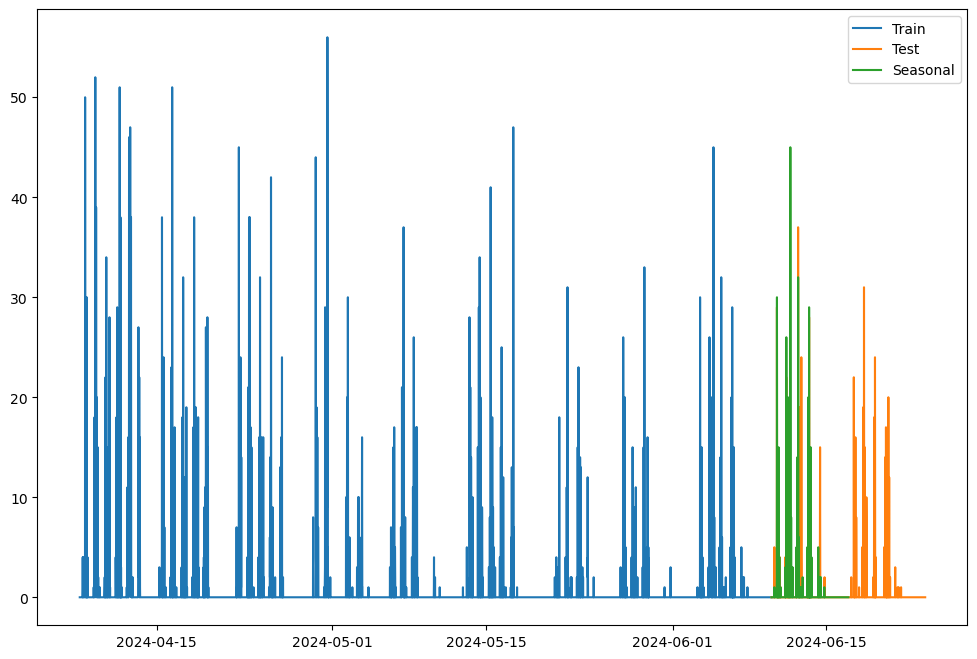

In [25]:
plot_results(trainset, testset, "event_type", preds, "Seasonal")

## 2.3 Linear Regression Models

Only try naive approach -> X = time, Y = Values

We could also add dummy variables

In [26]:
#import linear regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

X = trainset.index.values.astype(float).reshape(-1,1)

Y = trainset["event_type"].values


model = LinearRegression()
model.fit(X, Y)


LinearRegression()

In [27]:
preds = trainset.copy()
preds["linear"] = model.predict(X)
preds["linear"]

datetime
2024-04-08 00:00:00    1.510127
2024-04-08 00:15:00    1.509919
2024-04-08 00:30:00    1.509711
2024-04-08 00:45:00    1.509503
2024-04-08 01:00:00    1.509295
                         ...   
2024-06-09 22:45:00    0.253271
2024-06-09 23:00:00    0.253063
2024-06-09 23:15:00    0.252855
2024-06-09 23:30:00    0.252647
2024-06-09 23:45:00    0.252439
Name: linear, Length: 6048, dtype: float64

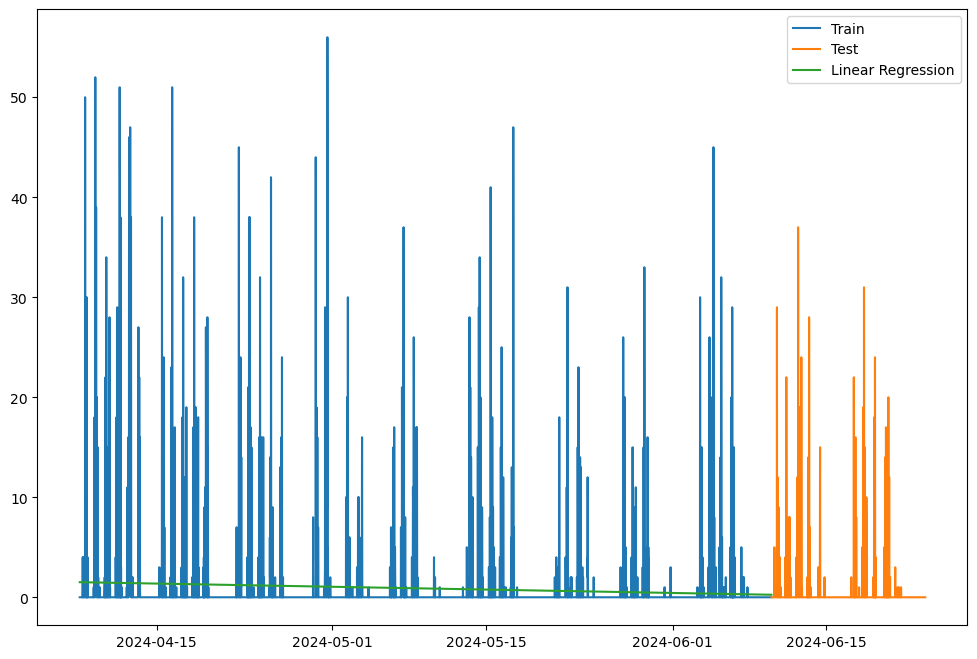

In [28]:
plot_results(trainset, testset, "event_type", preds["linear"], "Linear Regression")

## Add dummy variables

In [29]:
import statsmodels.api as sm

In [30]:
week_day_dummmies = pd.get_dummies(trainset.index.day_of_week, drop_first=False)
hour_dummies = pd.get_dummies(trainset.index.hour, drop_first=False)
minute_dummies = pd.get_dummies(trainset.index.minute, drop_first=True)

In [31]:
train_linspace = np.linspace(0, 10, len(X))
X_concat = np.concatenate((train_linspace.reshape(-1, 1), week_day_dummmies.values, hour_dummies.values, minute_dummies.values), axis=1)
X_concat = sm.add_constant(X_concat)

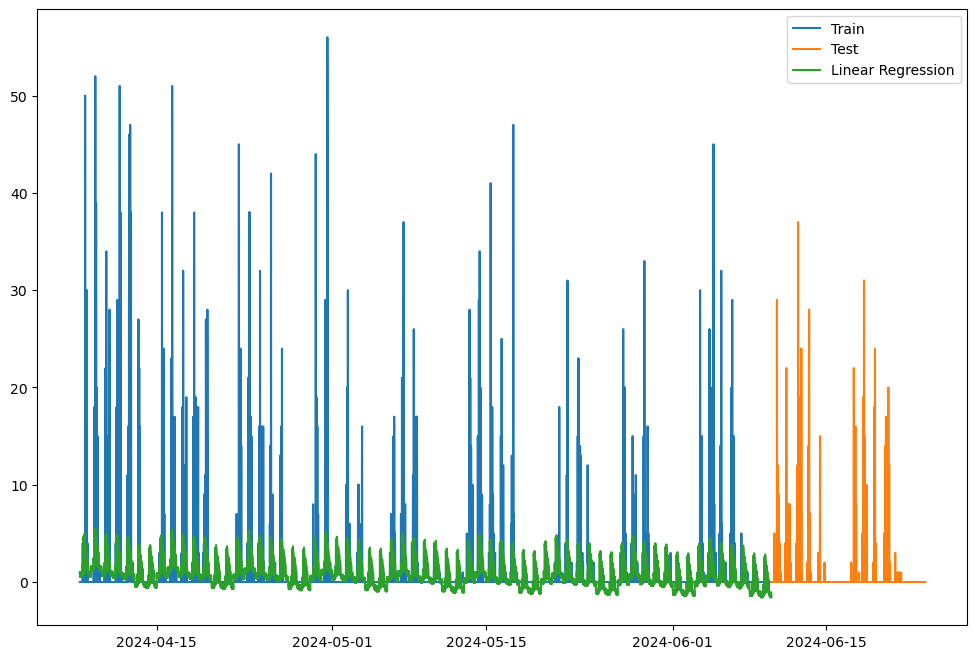

In [32]:
model = sm.OLS(Y, X_concat)
results = model.fit()
#print(results.summary())

preds = trainset.copy()
preds["linear"] = results.predict(X_concat)

plot_results(trainset, testset, "event_type", preds["linear"], "Linear Regression")

In [33]:
step_size = 10/len(X)
test_linspace = np.linspace(0, step_size * len(testset), len(testset)) + 10 + step_size

In [34]:
week_day_dummmies = pd.get_dummies(testset.index.day_of_week, drop_first=False)
hour_dummies = pd.get_dummies(testset.index.hour, drop_first=False)
minute_dummies = pd.get_dummies(testset.index.minute, drop_first=True)

X_test = np.concatenate((test_linspace.reshape(-1, 1), week_day_dummmies.values, hour_dummies.values, minute_dummies.values), axis=1)
X_test = sm.add_constant(X_test)

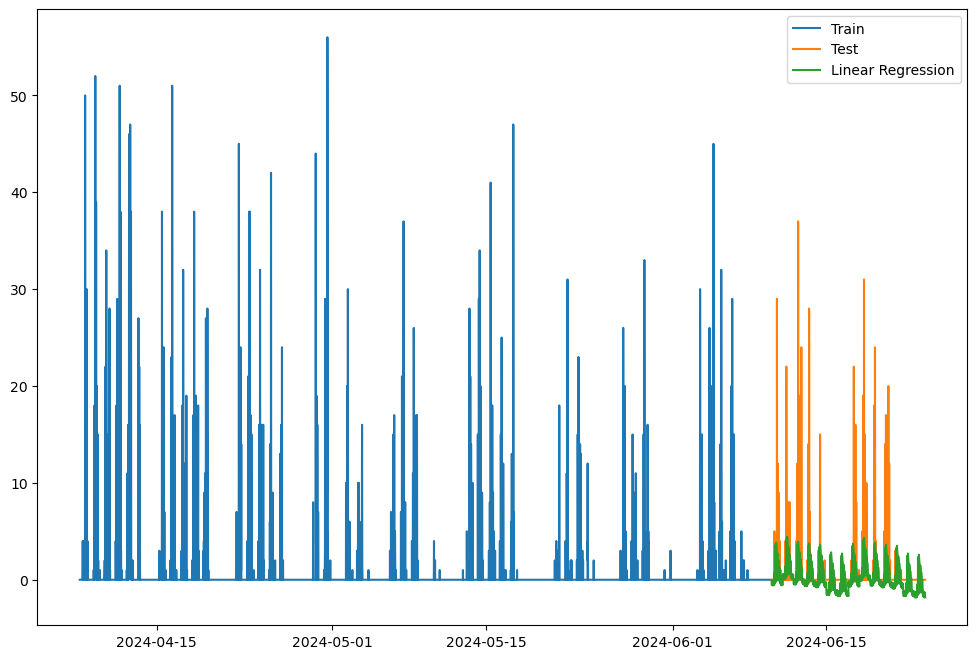

In [35]:
preds = testset.copy()
preds["linear"] = results.predict(X_test)

plot_results(trainset, testset, "event_type", preds["linear"], "Linear Regression")

# 3. Time Series Decomposition

## 3.1 Seasonal decomposition

Very nice!

### 3.1.1 Naive decomposition

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

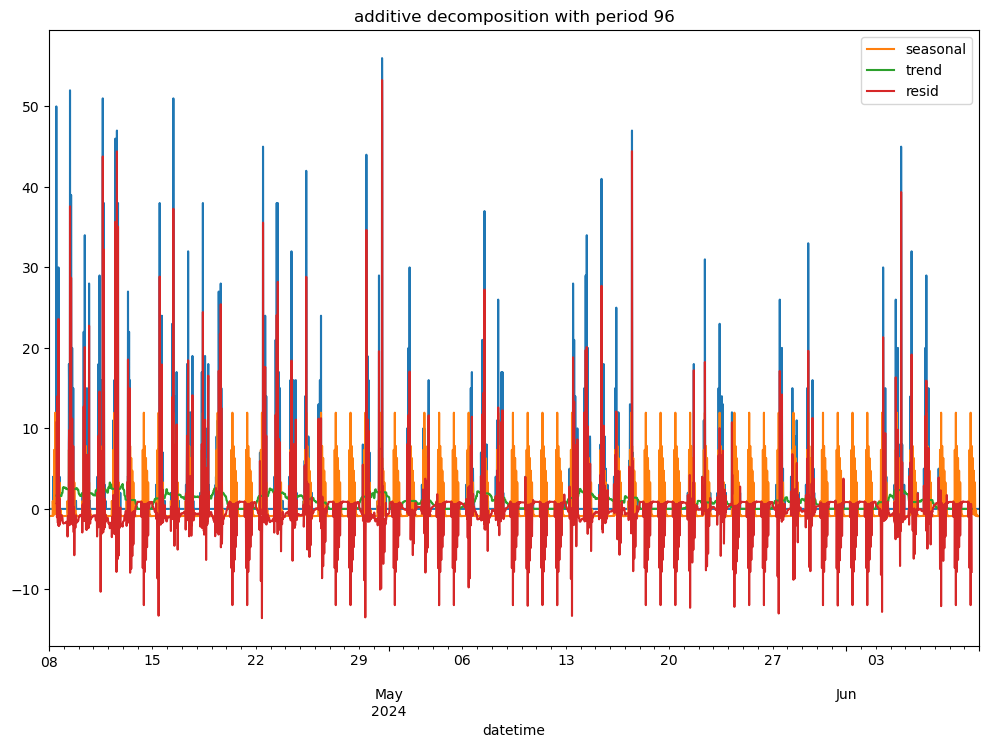

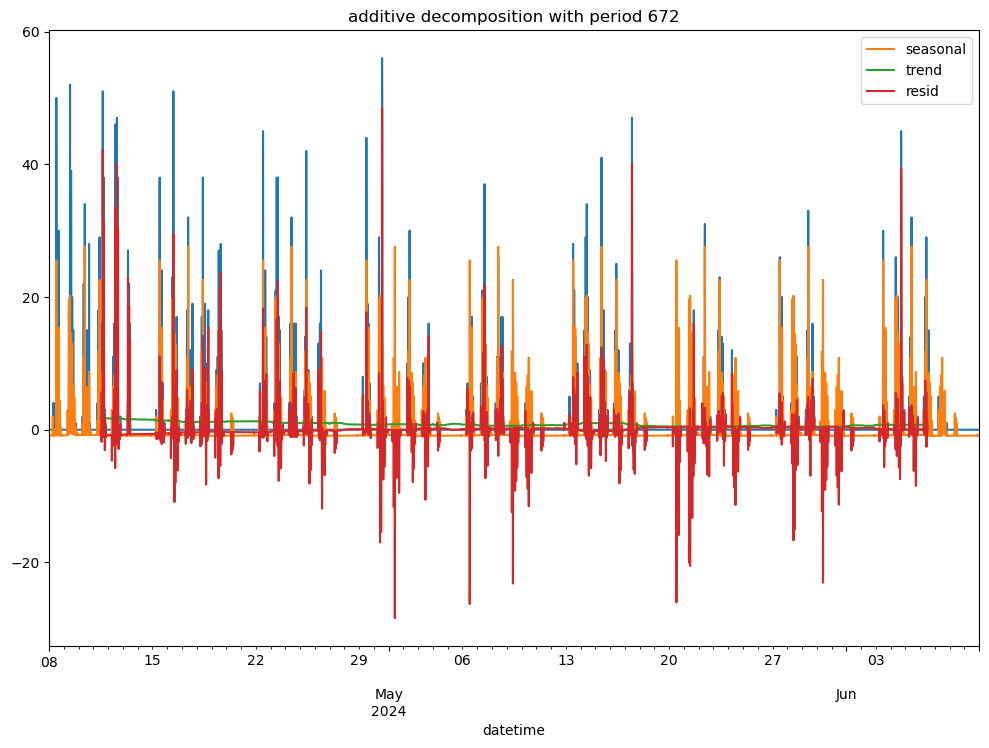

In [40]:
plot_df = trainset.copy()

periods = [4*24, 4*24*7]
models = ["additive"]
for model in models:
    for period in periods:
        results = seasonal_decompose(plot_df, model=model, period=period)

        plt.figure(figsize=(12,8))

        results.observed.plot()
        results.seasonal.plot()
        results.trend.plot()
        results.resid.plot()
        plt.title(f"{model} decomposition with period {period}")
        plt.legend(loc='best')
        plt.show()

### 3.1.2 STL/MSTL 

There also exist other methods which are not implemented in the statsmodel library

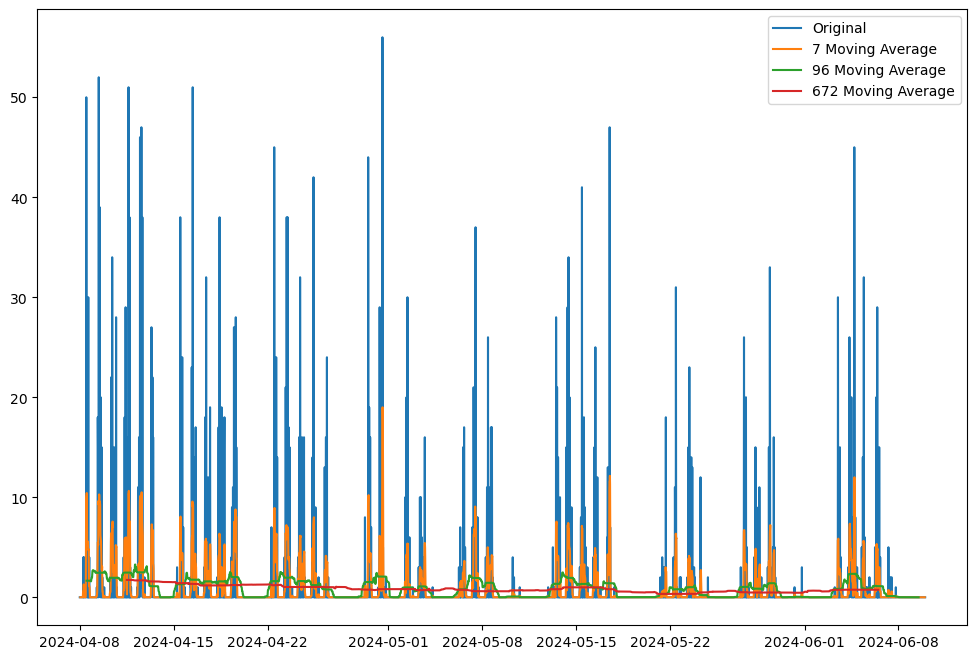

In [108]:
plot_df = trainset.copy()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plot_df.index, plot_df["event_type"], label='Original')


w_size = 7
plot_df[f"MA_{w_size}"] = trainset.rolling(window=w_size, center=True).mean().rolling(window=2, center=True).mean()
ax.plot(plot_df.index, plot_df[f"MA_{w_size}"], label=f'{w_size} Moving Average')

w_size = 96
plot_df[f"MA_{w_size}"] = trainset.rolling(window=w_size, center=True).mean().rolling(window=2, center=True).mean()
ax.plot(plot_df.index, plot_df[f"MA_{w_size}"], label=f'{w_size} Moving Average')

w_size = 672
plot_df[f"MA_{w_size}"] = trainset.rolling(window=w_size, center=True).mean().rolling(window=2, center=True).mean()
ax.plot(plot_df.index, plot_df[f"MA_{w_size}"], label=f'{w_size} Moving Average')



plt.legend(loc='best')
plt.show()

In [ ]:
trainset["MA"]= trainset.rolling(window=60).mean()

## 1.1 Raw events per hour

In [ ]:
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# get min time
min_time = min(data['time']).replace(hour=0, minute=0, second=0)

# get max time
max_time = max(data['time'])
max_time = max_time.replace(day=max_time.day+1, hour=0, minute=0, second=0)

In [ ]:

# hours between min and max time
total_seconds = (max_time - min_time).total_seconds()
hour1 = int(total_seconds/3600)
minutes15 = int(total_seconds/900)

nbinsx = minutes15
data_entering = data[data["event_type"]==1]
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=data_entering["time"],
    y=data_entering["event_type"],
    name="entering",
    nbinsx=nbinsx,
    )
)

data_exiting = data[data["event_type"]==0]
fig.add_trace(go.Histogram(
    x=data_exiting["time"],
    y=data_exiting["event_type"],
    name="exiting",
    nbinsx=nbinsx,
    )
)
fig.update_layout(width=600, height=400, bargap=0)
fig.show()


## 1.2) Raw Events per day

In [ ]:
# hours between min and max time
total_seconds = (max_time - min_time).total_seconds()
day1 = int(total_seconds/86400)

nbinsx = day1
data_entering = data[data["event_type"]==1]
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=data_entering["time"],
    y=data_entering["event_type"],
    name="entering",
    nbinsx=nbinsx,
    )
)

data_exiting = data[data["event_type"]==0]
fig.add_trace(go.Histogram(
    x=data_exiting["time"],
    y=data_exiting["event_type"],
    name="exiting",
    nbinsx=nbinsx,
    )
)
fig.update_layout(width=800, height=400, bargap=0)
fig.show()

# 2.) Analysis

## 2.1) Does it add up?

In [ ]:
# group data by day
data["day"] = data["time"].dt.date
data.groupby("day")["event_type"].value_counts()

# add week number
data["week"] = data["time"].dt.isocalendar().week
data.groupby("week")["event_type"].value_counts()

week  event_type
15    0             1935
      1             1906
16    0             1419
      1             1390
17    1             1371
      0             1318
18    0             1009
      1              962
19    0              860
      1              858
20    1             1235
      0             1224
21    0              600
      1              574
22    1              652
      0              576
23    1             1102
      0             1085
24    1             1007
      0              987
25    1              815
      0              803
26    0             1435
      1             1393
Name: count, dtype: int64

In [ ]:
# add week number
data["week"] = data["time"].dt.isocalendar().week
data.groupby("week")["event_type"].value_counts()

week  event_type
15    0             1935
      1             1906
16    0             1419
      1             1390
17    1             1371
      0             1318
18    0             1009
      1              962
19    0              860
      1              858
20    1             1235
      0             1224
21    0              600
      1              574
22    1              652
      0              576
23    1             1102
      0             1085
24    1             1007
      0              987
25    1              815
      0              803
26    0             1435
      1             1393
Name: count, dtype: int64

## 2.2) Does room utilization decrease?

If so what realtionship can we find in the data using correlation coefficients and curve fitting!

### Check what the assumptions for least squares solution are!

In [ ]:
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

In [ ]:
present_students = data.groupby("week")["event_type"].count()//2
present_students = present_students.reset_index()

In [ ]:
def fit_polynomial(x, y, degree):
    full_info = Polynomial.fit(x, y, degree, full=True)
    return full_info[0], full_info[1]

def fit_and_test(x, y, degree):
    polynomial, info = fit_polynomial(x, y, degree)
    y_pred = polynomial(x)
    r2 = r2_score(y, y_pred)r2_score
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return y_pred, r2, mse, mae, info

In [ ]:
# correlation coefficient
x_col = "week"
present_students = data.groupby(x_col)["event_type"].count()//2
present_students = present_students.reset_index()
x = present_students.index
y = present_students["event_type"]
stats.pearsonr(x, y)

PearsonRResult(statistic=-0.46817487716720685, pvalue=0.12478069274276446)

In [ ]:
#x = present_students.index
#y = present_students["event_type"]


#pred_list = []
#for degree in range(1, 5):
#    y_pred, r2, mse, mae, info = fit_and_test(x, y, degree)
#    pred_list.append([y_pred, r2, mse, mae, degree, info])

In [ ]:
## plot results 
#fig = plt.figure()
#plt.scatter(x, y, color='red')

#for pred in pred_list:
#    y_pred, r2, mse, mae, degree, info = pred
#    plt.plot(x, y_pred, label=f"degree: {degree}, r2: {r2:.2f}")
    
## make y-axis start at 0
#plt.ylim(bottom=0)
#plt.legend()
#plt.show()

## Correlation coefficients

In [ ]:
#stats.pearsonr(x, y)
#stats.spearmanr(x, y)
#stats.kendalltau(x, y)
#stats.linregress(x, y)

# Time Series Analysis

## Check what kinds of statistics they use for their analysis
https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

TODO:

Time series decomposition -> Trend, Seasonality,...

Stationarity?!

Forecasting
